# 03_baseline_models



In [136]:
import os
import math
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format
import logging

# Improve resolution of output graphcis
%config InlineBackend.figure_format ='retina'

In [4]:
file_path = '../data/interim/NYC_capital_projects_3yr.csv'
    
if os.path.isfile(file_path):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [5]:
data = pd.read_csv(file_path)

In [6]:
# entries
print(f"Number of dataset records: {len(data)}")

# num projects
print(f"Number of unique projects in dataset: {len(data['PID'].unique())}")

Number of dataset records: 149
Number of unique projects in dataset: 149


In [13]:
datetime_cols = [
    'Design_Start',
    'Final_Change_Date',
    'Schedule_Start',
    'Schedule_End',
]

for col in datetime_cols:
    data[col] = pd.to_datetime(data[col])

In [14]:
data.info()

data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PID                    149 non-null    int64         
 1   Project_Name           149 non-null    object        
 2   Description            149 non-null    object        
 3   Category               149 non-null    object        
 4   Borough                149 non-null    object        
 5   Managing_Agency        149 non-null    object        
 6   Client_Agency          149 non-null    object        
 7   Phase_Start            149 non-null    object        
 8   Current_Project_Years  149 non-null    float64       
 9   Current_Project_Year   149 non-null    int64         
 10  Design_Start           149 non-null    datetime64[ns]
 11  Budget_Start           149 non-null    float64       
 12  Schedule_Start         149 non-null    datetime64[ns]
 13  Final

,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Phase_Start,Current_Project_Years,Current_Project_Year,...,Schedule_Change,Budget_Change,Schedule_Change_Ratio,Budget_Change_Ratio,Budget_Abs_Per_Error,Budget_Rel_Per_Error,Duration_End_Ratio,Budget_End_Ratio,Duration_Ratio_Inv,Budget_Ratio_Inv
0,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,2-Design,5.94,6,...,91,"-15,619,967.29",0.04,-0.08,0.09,0.08,1.04,0.92,-0.04,0.09
1,7,Bowery Bay Waste Water Treatment Plant Main Se...,The existing Main Sewage Pumps have deteriorat...,Wastewater Treatment,Queens,DEP,DEP,2-Design,6.34,7,...,334,"9,618,785.30",0.19,0.18,0.15,0.18,1.19,1.18,-0.16,-0.15
2,91,Mill Basin Bridge Replacement,Complete replacement of bascule bridge with a ...,Bridges,Brooklyn,DOT,not_specified,2-Design,7.44,8,...,247,"-34,672,662.00",0.09,-0.09,0.10,0.09,1.09,0.91,-0.08,0.10


## Inspect projects by category

Can any categories be combined to better balance and reduce the number of categories for one-hot-encoding in the baseline model. 

In [61]:
category_values = data['Category'].value_counts()
category_names = category_values.index

print(category_values)
print('\n')
for name in category_names:
    print(name.upper())
    print()
    for project in data.loc[data['Category']==name]['Project_Name']:
        print(project)
    print('\n')

Streets and Roadways                  31
Sewers                                20
Schools                               15
Industrial Development                15
Wastewater Treatment                  13
Water Supply                          13
Bridges, Streets and Roadways          9
Bridges                                7
Sanitation                             6
Other Government Facilities            4
Public Safety and Criminal Justice     4
Ferries                                3
Health and Hospitals                   3
Parks                                  2
Arts and Culture                       2
Parks, Streets and Roadways            1
Industrial Development, Parks          1
Name: Category, dtype: int64


STREETS AND ROADWAYS

Bergen Avenue Street Reconstruction
Dumbo and Vinegar Hill Area Roadway Reconstruction and Renovation
Edgewood Triangle Roadway Reconstruction
Battery Park Underpass Sandy Flood Damage Repair
Gansevoort Area Roadway Reconstruction
Woodhaven Blvd SBS


In [62]:
magency_values = data['Managing_Agency'].value_counts()
magency_names = magency_values.index

print(magency_values)
print('\n')
for name in magency_names:
    print(name.upper())
    print()
    for project in data.loc[data['Managing_Agency']==name]['Project_Name']:
        print(project)
    print('\n')

DDC     63
DOT     34
DEP     19
SCA     15
EDC     14
DSNY     2
DCAS     2
Name: Managing_Agency, dtype: int64


DDC

Bergen Avenue Street Reconstruction
West 30th Street Trunk Water Main Installations, Phase 2
Pugsley Creek Sewer Relief and Water Main Repair
Queens Water Main New Installations
Dumbo and Vinegar Hill Area Roadway Reconstruction and Renovation
Edgewood Triangle Roadway Reconstruction
West 59th Street Marine Transfer Station Construction, Phase 2
Flatbush Avenue Trunk Watermain Replacement
Fresh Creek Basin Sewers Construction, Phase II
Baisley Boulevard Sewers and Watermain Construction
Fresh Creek Basin Sewers Construction, Phase III
2nd Avenue Watermain Trunk Construction
Francis Lewis Boulevard Construction
Fresh Creek Basin Sewers Construction, Phase I
Gansevoort Area Roadway Reconstruction
Hudson Yards Cultural Shed Facility New Construction
20th Avenue Storm and Sanitary Sewer Construction
Bainbridge Avenue Trunk Water Main
Ped Safety Upgrades on Atlantic Avenue

In [63]:
cagency_values = data['Client_Agency'].value_counts()
cagency_names = cagency_values.index

print(cagency_values)
print('\n')
for name in cagency_names:
    print(name.upper())
    print()
    for project in data.loc[data['Client_Agency']==name]['Project_Name']:
        print(project)
    print('\n')

DEP                    53
not_specified          35
DOT                    17
DOE                    15
DSNY                    7
DCAS                    4
DPR                     3
H+H                     3
DCLA                    2
DEP, EDC                1
DHS                     1
DOT, Mayor's Office     1
EDC                     1
DOHMH, HHC              1
DSBS                    1
BWS                     1
NYPD                    1
Mayor's Office          1
ORR                     1
Name: Client_Agency, dtype: int64


DEP

26th Ward Waste Water Treatment Plant Preliminary Treatment Improvements
Bowery Bay Waste Water Treatment Plant Main Sewage Pump Controls and Piping Replacements
West 30th Street Trunk Water Main Installations, Phase 2
Pugsley Creek Sewer Relief and Water Main Repair
Queens Water Main New Installations
Wards Island Water Pollution Control Plant final Settling Tank Rehabilitation
Hannah Street Pumping Station Construction
Coney Island Biological Nutrient Constru

In [64]:
borough_values = data['Borough'].value_counts()
borough_names = borough_values.index

print(borough_values)
print('\n')
for name in borough_names:
    print(name.upper())
    print()
    for project in data.loc[data['Borough']==name]['Project_Name']:
        print(project)
    print('\n')

not_specified                      47
Brooklyn                           30
Queens                             19
Manhattan                          17
Bronx                              12
Staten Island                       9
Citywide                            5
New York                            2
Valhalla                            2
Olive                               1
Brooklyn, Queens                    1
Manhattan, Staten Island, Bronx     1
Port Jervis                         1
Manhattan, Bronx                    1
Marlboro                            1
Name: Borough, dtype: int64


NOT_SPECIFIED

New Ferry Boat Construction
Woodhaven Blvd SBS
Grand Concourse, Phase 3
Grand Concourse Reconstruction, Phase 4 (Great Streets)
Queens Boulevard Reconstruction (Great Streets)
Hunters Point Street Reconstruction (Long Island City)
Brookville-Edgewood Triangle Reconstruction
FDR Rehabilitation, Northbound (East 42nd to 49th Streets)
Ped Safety Upgrades on Atlantic Avenue, Phase 2
Hen

## Subset and scale data for X and y frames

In [68]:
def standardize_features(train_df, val_df, exclude_scale_cols):
    """
    Scales val_df features based on train_df mean and std for each feature
    and returns the scaled dataframe. To specify features not to scale,
    use the exclude_scale_cols parameter
    
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param exclude_scale_cols: Optional list containing names of columns we
                               do not wish to scale
    :return: a feature-scaled version of the val_df dataframe, and standard
             scaler fitted object used to scale values
    """
    # create list of non-binary column names for scaling
    scaled_columns = train_df.columns.difference(exclude_scale_cols)
    
    # create StandardScaler instance fitted on non-binary train data
    Scaler = StandardScaler().fit(
        train_df[scaled_columns]
    )
    
    # scale val_df and convert to dataframe with column names
    scaled_df = pd.DataFrame(
        Scaler.transform(val_df[scaled_columns]),
        columns=scaled_columns,
    )
    
    # merge scaled columns with unscaled columns
    scaled_df = pd.concat(
        [
            val_df.drop(scaled_columns, axis=1).reset_index(drop=True),
            scaled_df.copy()
        ],
        axis=1,
    )
    # Return full dataframe and fitted Scaler object
    return scaled_df, Scaler

In [137]:
def normalize_features(train_df, val_df, exclude_scale_cols):
    """
    Scales val_df features based on train_df mean and std for each feature
    and returns the scaled dataframe. To specify features not to scale,
    use the exclude_scale_cols parameter
    
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param exclude_scale_cols: Optional list containing names of columns we
                               do not wish to scale
    :return: a feature-scaled version of the val_df dataframe, and standard
             scaler fitted object used to scale values
    """
    # create list of non-binary column names for scaling
    scaled_columns = train_df.columns.difference(exclude_scale_cols)
    
    # create StandardScaler instance fitted on non-binary train data
    Scaler = MinMaxScaler().fit(
        train_df[scaled_columns]
    )
    
    # scale val_df and convert to dataframe with column names
    scaled_df = pd.DataFrame(
        Scaler.transform(val_df[scaled_columns]),
        columns=scaled_columns,
    )
    
    # merge scaled columns with unscaled columns
    scaled_df = pd.concat(
        [
            val_df.drop(scaled_columns, axis=1).reset_index(drop=True),
            scaled_df.copy()
        ],
        axis=1,
    )
    # Return full dataframe and fitted Scaler object
    return scaled_df, Scaler

In [138]:
X_cols = [
    'Budget_Start',
    'Duration_Start',
]

y_cols = [
    'Budget_Change',
    'Schedule_Change'
]


In [139]:
X, y = data[X_cols], data[y_cols]

In [140]:
random_state = 0
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    shuffle=True
)

In [141]:
# Identify columns to exclude from scaling (i.e. binary and non-predictor columns)
exclude_scale_cols = []

In [142]:
#######################################
# CREATE SCALED DATAFRAMES
#######################################

# Perform standard scaling on both X_train and X_test data, fitting X_train as the
# scaler for both
X_train_scaled, Scaler = standardize_features(
    X_train, X_train,
    exclude_scale_cols)

X_test_scaled, Scaler = standardize_features(
    X_train, X_test,
    exclude_scale_cols)


# Perform normalized scaling on both X_train and X_test data, fitting X_train as the
# scaler for both
X_train_norm, Scaler_norm = normalize_features(
    X_train, X_train,
    exclude_scale_cols)

X_test_norm, Scaler_norm = normalize_features(
    X_train, X_test,
    exclude_scale_cols)


In [143]:
# create X_scaler dataframe for restoring stored values later on in analysis
X_scaler = pd.DataFrame(
    np.hstack([
        np.array(X_train_scaled.drop(columns=exclude_scale_cols).columns).reshape(-1,1),
        Scaler.scale_.reshape(-1,1),
        Scaler.mean_.reshape(-1,1)
    ]),
    columns=['scaled-feature', 'std', 'mean']
)

# # create X_scaler dataframe for restoring stored values later on in analysis
# X_scaler_norm = pd.DataFrame(
#     np.hstack([
#         np.array(X_train.drop(columns=exclude_scale_cols).columns).reshape(-1,1),
#         Scaler.scale_.reshape(-1,1),
#         Scaler.mean_.reshape(-1,1)
#     ]),
#     columns=['scaled-feature', 'std', 'mean']
# )


# check results
X_scaler.info()
X_scaler.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   scaled-feature  2 non-null      object
 1   std             2 non-null      object
 2   mean            2 non-null      object
dtypes: object(3)
memory usage: 176.0+ bytes


,scaled-feature,std,mean
0,Budget_Start,"212,079,631.87","103,184,747.88"
1,Duration_Start,639.62,"1,956.11"


In [144]:
X_train_norm.describe()

,Budget_Start,Duration_Start
count,134.00,134.00
mean,0.05,0.35
std,0.11,0.17
min,0.00,0.00
25%,0.02,0.23
50%,0.03,0.33
75%,0.04,0.43
max,1.00,1.00


In [145]:
X_test_norm.describe()

,Budget_Start,Duration_Start
count,15.00,15.00
mean,0.04,0.32
std,0.05,0.18
min,0.01,0.03
25%,0.02,0.20
50%,0.02,0.30
75%,0.04,0.42
max,0.16,0.70


In [146]:
X_train_sig = np_sigmoid(X_train_scaled)
X_test_sig = np_sigmoid(X_test_scaled)

X_train_log = np.log(X_train_norm+1)
X_test_log = np.log(X_test_norm+1)

In [147]:
X_train_log.describe()

,Budget_Start,Duration_Start
count,134.00,134.00
mean,0.05,0.29
std,0.08,0.12
min,0.00,0.00
25%,0.02,0.20
50%,0.03,0.29
75%,0.04,0.36
max,0.69,0.69


In [102]:
print('{}\t{}'.format(X_train.shape, y_train.shape))
print('{}\t\t{}'.format(X_test.shape, y_test.shape))

(134, 2)	(134, 2)
(15, 2)		(15, 2)


In [103]:
print('{}\t{}'.format(X_train_scaled.shape, y_train.shape))
print('{}\t\t{}'.format(X_test_scaled.shape, y_test.shape))

(134, 2)	(134, 2)
(15, 2)		(15, 2)


In [104]:
def score_outputs(y_train, y_test, pred_train, pred_test):
    """
    """
    if type(y_train)==pd.core.frame.DataFrame:
        y_train = y_train.values
        
    if type(y_test)==pd.core.frame.DataFrame:
        y_test = y_test.values
        
    score_train = [
        r2_score(true, pred) for true, pred in zip(y_train.T, pred_train.T)
    ]
    score_test = [
        r2_score(true, pred) for true, pred in zip(y_test.T, pred_test.T)
    ]
    
    return score_train, score_test

In [105]:
LinReg = LinearRegression()
LinReg.fit(X_train_scaled, y_train)
pred_train = LinReg.predict(X_train_scaled)
pred_test = LinReg.predict(X_test_scaled)
score_train = r2_score(y_train, pred_train)
score_test = r2_score(y_test, pred_test)

In [106]:
score_outputs(y_train, y_test, pred_train, pred_test)

([0.07645560085392966, 0.0740551717265594],
 [-0.04207160171390911, 0.17907057183667097])

In [113]:
def np_sigmoid(x):
    """
    """
    return 1/(1 + np.exp(-x)) 

In [179]:
type(None)

NoneType

In [231]:
def plot_budget_schedule(X, X_scaled, scale_descr, X_test=None, X_test_scaled=None):
    """
    """
    corr = np.corrcoef(X.T)[0, 1]
    corr_scaled = np.corrcoef(X_scaled.T)[0, 1]

    fig, ax = plt.subplots(1,2, figsize=(12,6))
    
    
    for i, (data, data_test) in enumerate(zip([X, X_scaled], [X_test, X_test_scaled])):
        ax[i].scatter(
            *data.values.T,
            color='k',
            alpha=0.5,
            edgecolor='w',
            s=80,
            label='training obs'
        )
        ax[i].set_title(
            'Original data\n({:.2f} pearson coefficient)'.format(corr) if i==0
            else '{} scaled\n({:.2f} pearson coefficient)'.format(scale_descr, corr_scaled),
            fontsize=14
        )
        ax[i].set_xlabel('Budget', fontsize=12)
        if i==0:
            ax[i].set_ylabel('Duration', fontsize=12)

        if type(X_test)!='NoneType':
            ax[i].scatter(
                *data_test.values.T,
                color='tab:orange',
                alpha=1,
                edgecolor='w',
                marker='s',
                s=80,
                label='test obs'
            )
            ax[0].legend(fontsize=12, edgecolor='k', loc=4)
            
        ax[i].grid(':', alpha=0.4)
    plt.tight_layout()
    plt.show();

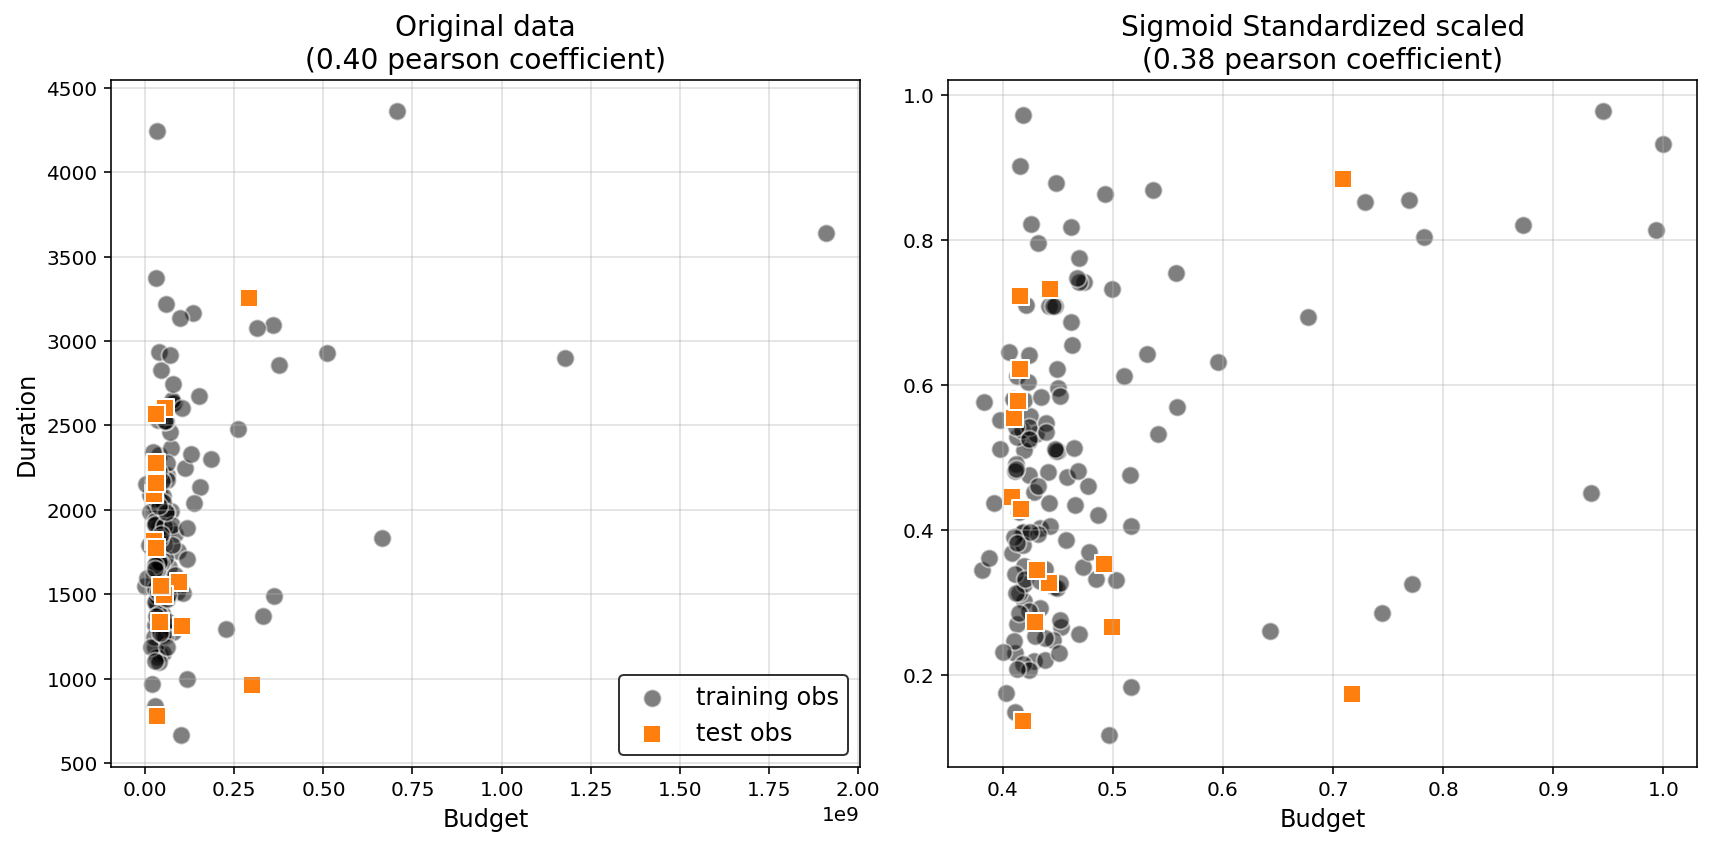

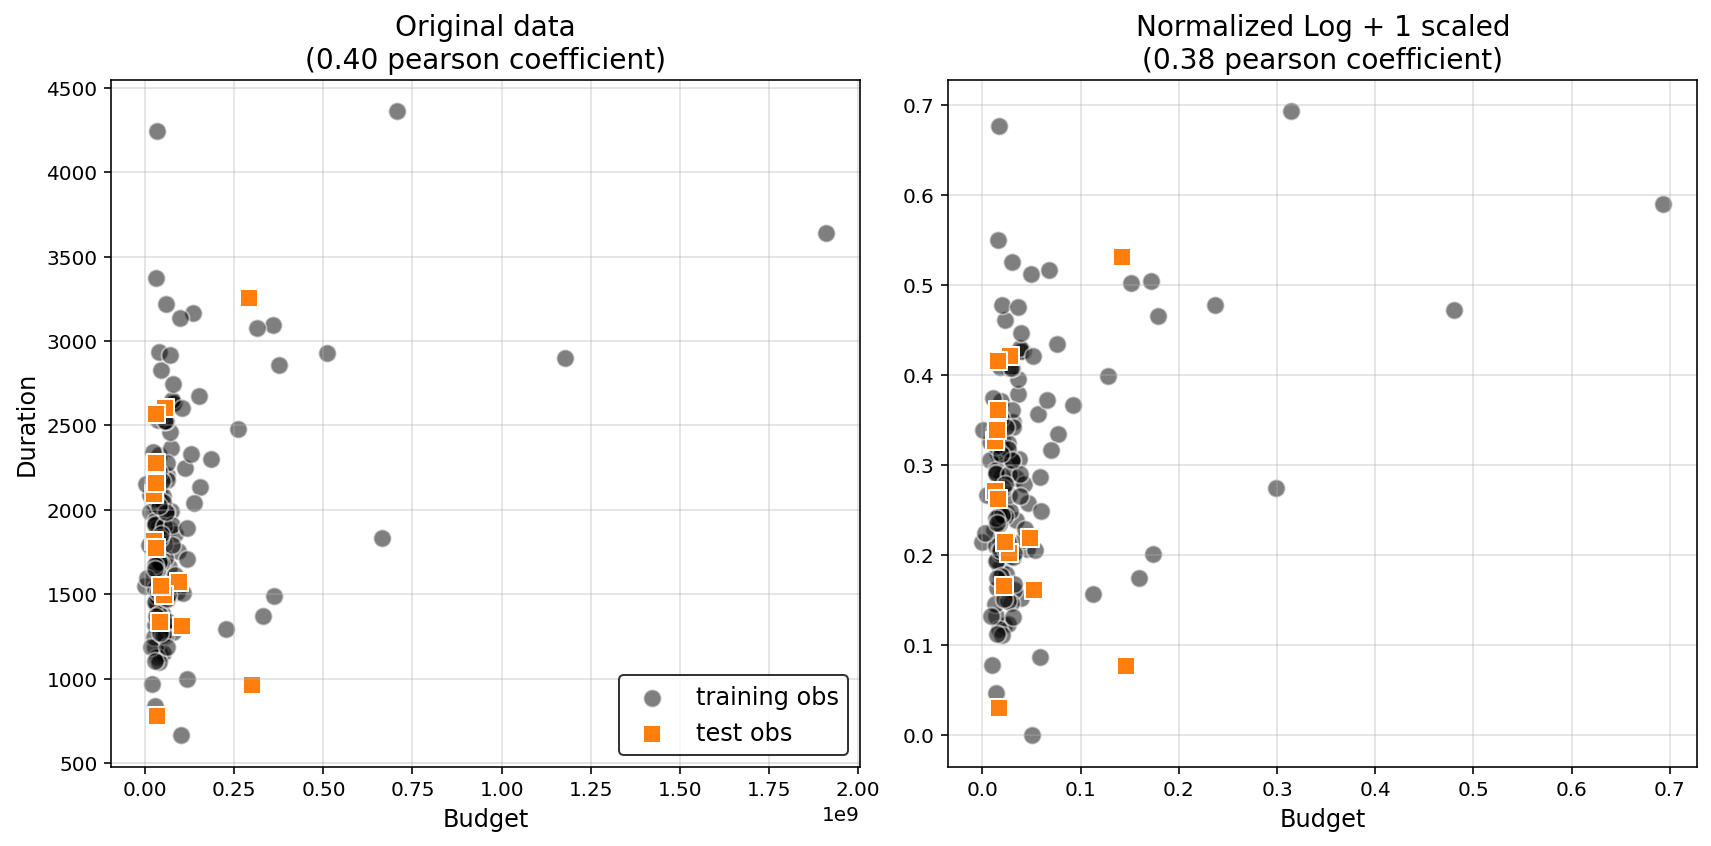

In [233]:
plot_budget_schedule(X_train, X_train_sig, 'Sigmoid Standardized', X_test, X_test_sig)
plot_budget_schedule(X_train, X_train_log, 'Normalized Log + 1', X_test, X_test_log)

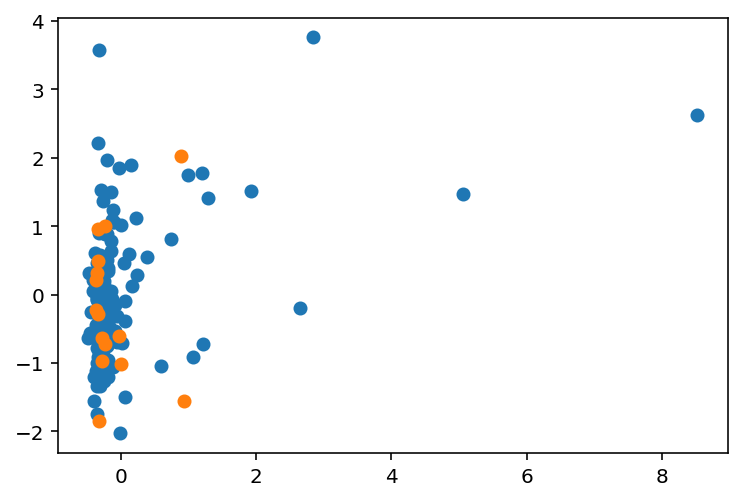

corr coef pearson:
[[1.         0.39599986]
 [0.39599986 1.        ]]


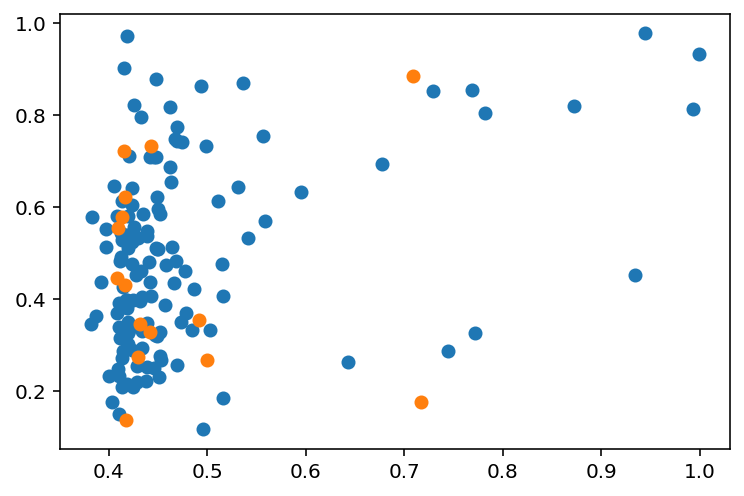

corr coef pearson:
[[1.         0.37767092]
 [0.37767092 1.        ]]


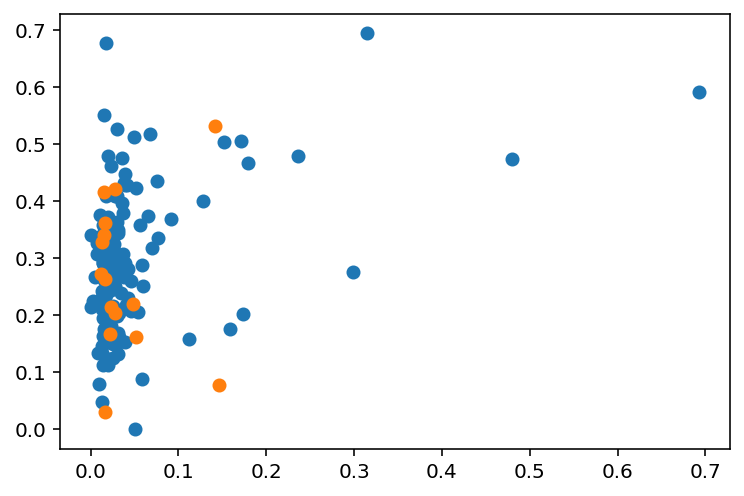

corr coef pearson:
[[1.         0.38416031]
 [0.38416031 1.        ]]


In [148]:
plt.scatter(*X_train_scaled.values.T)
plt.scatter(*X_test_scaled.values.T)
plt.show();
print('corr coef pearson:\n{}'.format(np.corrcoef(X_train_scaled.T)))


plt.scatter(*X_train_sig.values.T)
plt.scatter(*X_test_sig.values.T)
plt.show();
print('corr coef pearson:\n{}'.format(np.corrcoef(X_train_sig.T)))

plt.scatter(*X_train_log.values.T)
plt.scatter(*X_test_log.values.T)
plt.show();
print('corr coef pearson:\n{}'.format(np.corrcoef(X_train_log.T)))

In [121]:
LinReg = LinearRegression()
LinReg.fit(X_train_sig, y_train)
pred_train = LinReg.predict(X_train_sig)
pred_test = LinReg.predict(X_test_sig)
score_train = r2_score(y_train, pred_train)
score_test = r2_score(y_test, pred_test)

In [122]:
score_outputs(y_train, y_test, pred_train, pred_test)

([0.10799612779875334, 0.0662089049849558],
 [-0.9163101329216012, 0.20420024495648714])

In [149]:
LinReg = LinearRegression()
LinReg.fit(X_train_log, y_train)
pred_train = LinReg.predict(X_train_log)
pred_test = LinReg.predict(X_test_log)
score_train = r2_score(y_train, pred_train)
score_test = r2_score(y_test, pred_test)

In [150]:
score_outputs(y_train, y_test, pred_train, pred_test)

([0.09214302920999573, 0.084079658562499],
 [-0.1598473827889062, 0.20969809973494313])

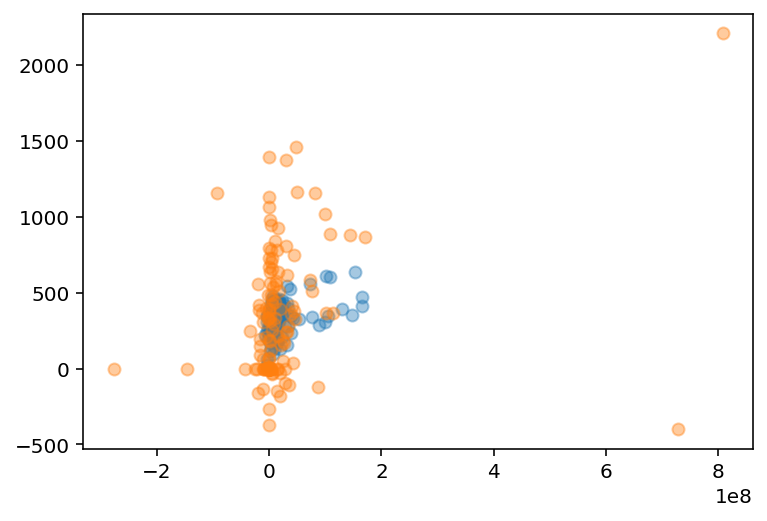

In [123]:
plt.scatter(pred_train[:, 0], pred_train[:, 1], alpha=0.4)
plt.scatter(y_train['Budget_Change'].values, y_train['Schedule_Change'].values, alpha=0.4)

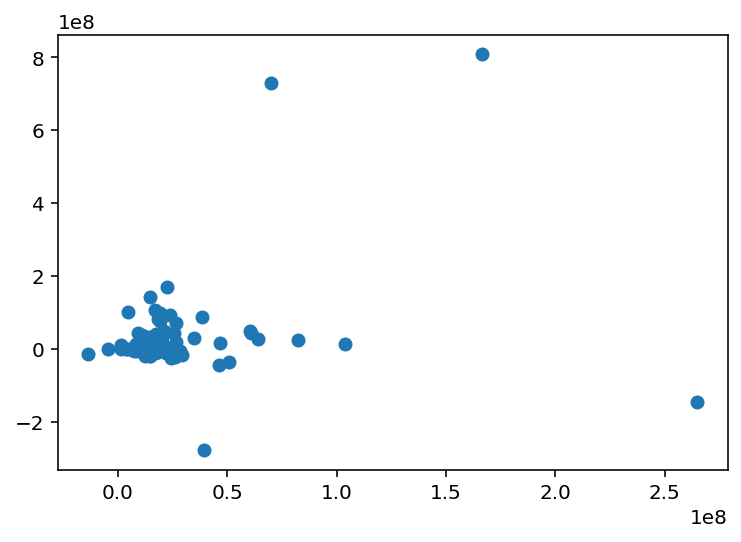

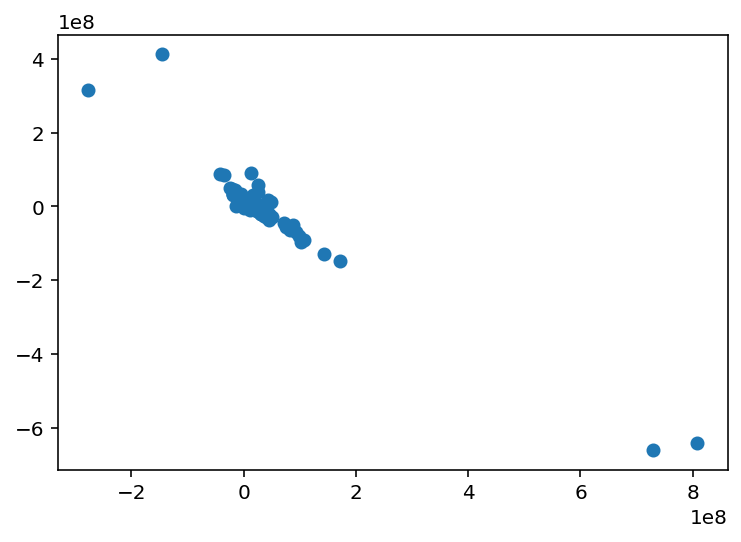

In [80]:
plt.scatter(pred_train[:, 0], y_train['Budget_Change'].values)
plt.show();

plt.scatter(y_train['Budget_Change'].values, pred_train[:, 0]-y_train['Budget_Change'].values)
plt.show();

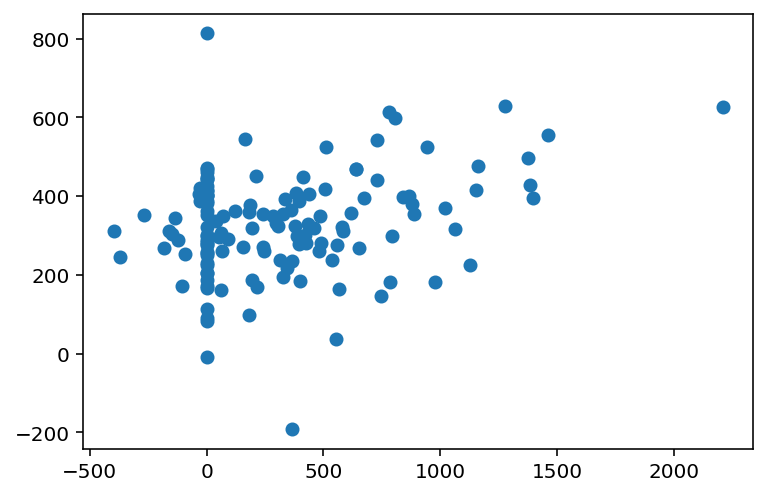

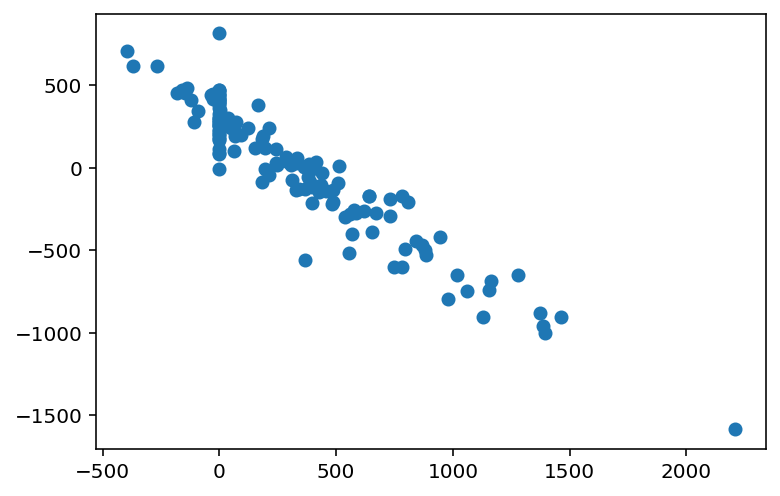

In [81]:
plt.scatter(y_train['Schedule_Change'].values, pred_train[:, 1])
plt.show();

plt.scatter(y_train['Schedule_Change'].values, pred_train[:, 1]-y_train['Schedule_Change'].values)
plt.show();

In [32]:
y_train

,Budget_Change,Schedule_Change
14,"4,772,000.00",654
83,"4,852,287.00",-34
105,0.00,0
28,"48,000,000.00",1461
120,"20,759,000.00",154
...,...,...
33,"29,558,000.00",196
75,"13,644,140.00",783
143,0.00,0
141,"-3,769,531.00",0
